In [1]:
import json
from operator import index
import os
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import pickle
import time

from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import ExtraTreesRegressor
import xgboost as xgb
import tensorflow as tf

from sklearn.model_selection import train_test_split

from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import warnings
warnings.filterwarnings('ignore', '.*sliced data.*', )

2022-03-02 07:43:33.814910: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-02 07:43:33.814994: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [5]:
def prepare_dataset(path : str, workload_name : str):
    dataset = {}
    files = os.listdir(path)

    for file in files:
        with open(path+"/"+file, "r") as f:
            raw_str = f.read()
        data = json.loads(raw_str)

        if "layers" in data.keys():
            del data["layers"]

        if "relay" in data.keys():
            del data["relay"]

        if "conv2d" in workload_name:
            data["kernel_0"] = data["kernel"][0]
            data["kernel_1"] = data["kernel"][1]
            del data["kernel"]
            data["dilation_0"] = data["dilation"][0]
            data["dilation_1"] = data["dilation"][1]
            del data["dilation"]

            if not "kernel layout" in data.keys():
                data["kernel layout"] = "OIHW"

        elif workload_name == "dense":
            data["features"] = data["input shape"][1]
            del data["input shape"]
            del data["output shape"]
            #print()

        elif workload_name in ["max_pool2d", "avg_pool2d"]:
            data["pool_0"] = data["pool_size"][0]
            data["pool_1"] = data["pool_size"][1]
            del data["pool_size"]

        if workload_name in ["max_pool2d", "avg_pool2d", "conv2d", "dilated_conv2d", "depthwise_conv2d"]:
            del data["padding"]
            data["C_I"] = data["input shape"][3]
            data["H_I"] = data["input shape"][1]
            data["W_I"] = data["input shape"][2]
            del data["input shape"]

            data["C_O"] = data["output shape"][3]
            data["H_O"] = data["output shape"][1]
            data["W_O"] = data["output shape"][2]
            del data["output shape"]

            key = "strides"
            if "stride" in data.keys():
                key = "stride"
            #print(key)
            data["strides_0"] = data[key][0]
            data["strides_1"] = data[key][1]
            del data["strides"]
            if "stride" in data.keys():
                del data["stride"]

        dataset[file] = data

    return dataset

def create_dataframe(dataset : dict, workload_name : str, labels = ["time", "power", "memory"], duplicate_removal=True):
    df = pd.DataFrame.from_dict(dataset, orient='index')
    categoricals = [
        "output dtype",
        "compute dtype",
        "workload",
        ]
    if workload_name in ["conv2d", "max_pool2d", "avg_pool2d", "depthwise_conv2d", "dilated_conv2d"]:
        if "data_layout" in list(df.columns):
            categoricals += [
                #"padding",
                "data_layout",
            ]
        else:    
            categoricals += [
                #"padding",
                "data layout",
            ]
        

    if "conv2d" in workload_name:
        if "kernel_layout" in list(df.columns):
            categoricals += [
                "kernel_layout",
            ]
        if "kernel layout" in list(df.columns):
            categoricals += [
                "kernel layout",
            ]

    for col in categoricals:
        oh = pd.get_dummies(df[col], prefix=col, drop_first=False)
        df = pd.concat([df, oh], axis=1).drop(col, axis=1)
    
    features = list(df.columns)
    #labels = ["time", "power", "memory"]
    for label in labels:
        idx = features.index(label)
        del features[idx]
    del idx
    if duplicate_removal:
        df = df.drop_duplicates(subset=features)

    label_data = []
    for label in labels:
        label_data.append(df[label])
        df.pop(label)

    output = pd.concat(label_data, axis=1)

    return df, output

In [3]:
dataset_base = "./dataset"
targets = os.listdir(dataset_base)

layer_targets = list()
for target in targets:
    target_path = dataset_base + "/" + target
    layers = os.listdir(target_path)
    
    for layer in layers:
        dataset_path = target_path + "/" + layer + "/"
        print(dataset_path)
        layer_targets.append(dataset_path)

print("found {0} folders with samples, going to train models for each of these targets".format(len(layer_targets)))
print()

./dataset/cuda_980ti/avg_pool2d/
./dataset/cuda_980ti/conv2d/
./dataset/cuda_980ti/dense/
./dataset/cuda_980ti/depthwise_conv2d/
./dataset/cuda_980ti/dilated_conv2d/
./dataset/cuda_980ti/max_pool2d/
./dataset/cuda_A100/avg_pool2d/
./dataset/cuda_A100/conv2d/
./dataset/cuda_A100/dense/
./dataset/cuda_A100/depthwise_conv2d/
./dataset/cuda_A100/dilated_conv2d/
./dataset/cuda_A100/max_pool2d/
./dataset/cuda_K80/avg_pool2d/
./dataset/cuda_K80/conv2d/
./dataset/cuda_K80/dense/
./dataset/cuda_K80/depthwise_conv2d/
./dataset/cuda_K80/dilated_conv2d/
./dataset/cuda_K80/max_pool2d/
./dataset/llvm -mcpu=haswell_E5-2680/avg_pool2d/
./dataset/llvm -mcpu=haswell_E5-2680/conv2d/
./dataset/llvm -mcpu=haswell_E5-2680/dense/
./dataset/llvm -mcpu=haswell_E5-2680/depthwise_conv2d/
./dataset/llvm -mcpu=haswell_E5-2680/dilated_conv2d/
./dataset/llvm -mcpu=haswell_E5-2680/max_pool2d/
./dataset/rasp4b/conv2d/
found 25 folders with samples, going to train models for each of these targets



conv2d : rasp4b	:	 contains 9031 samples
	[INFO] Remaining Samples after duplicate elimination:	1909


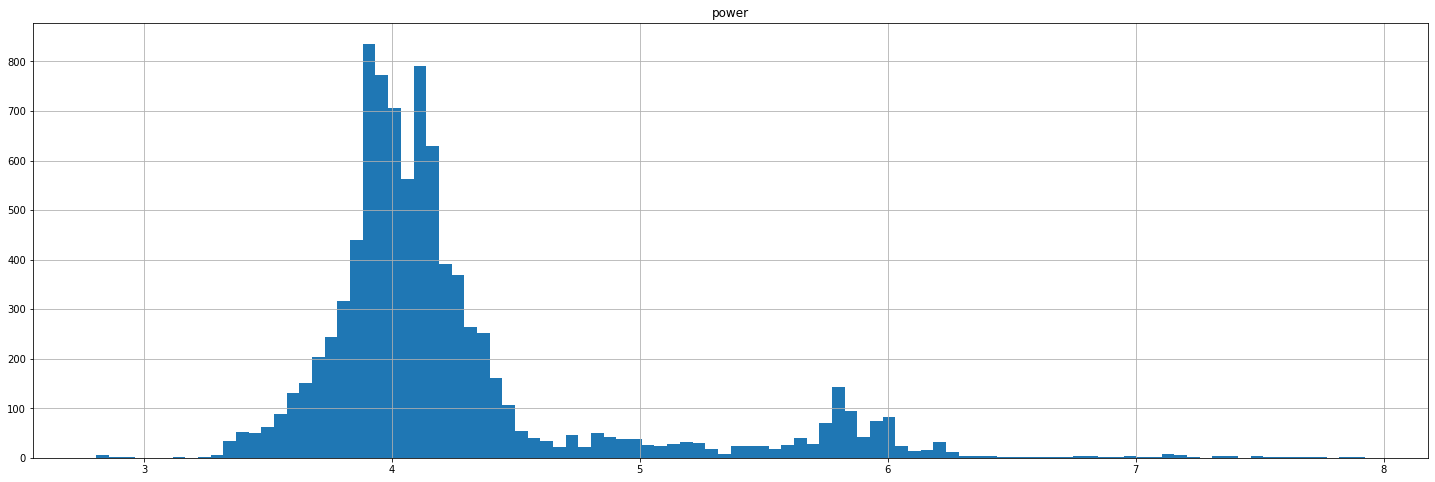

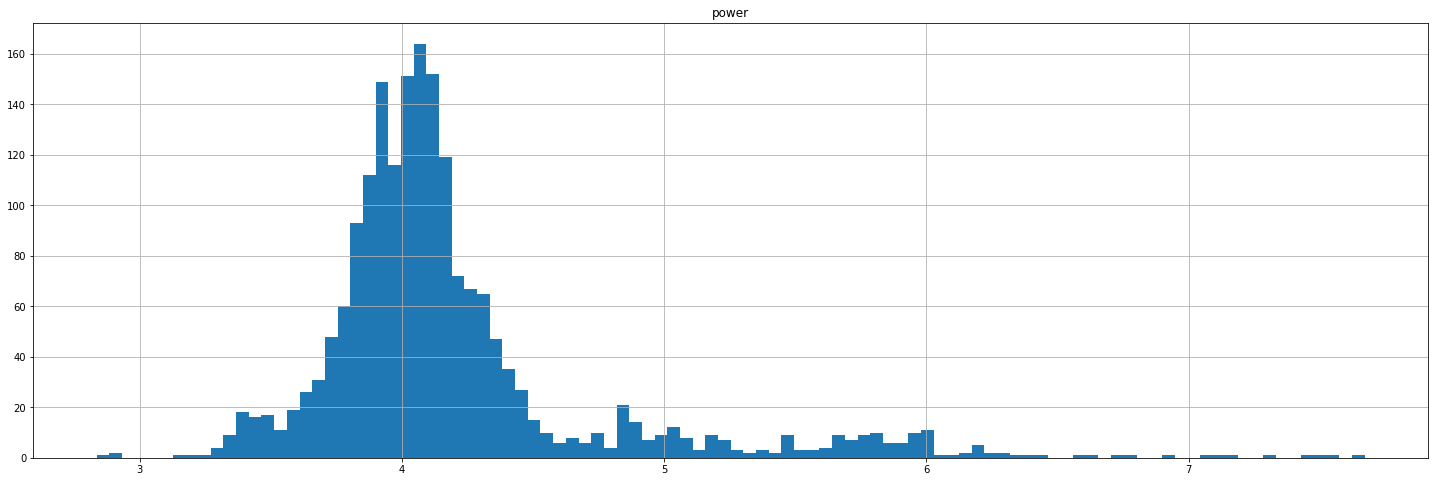

In [7]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (25,8)
dataset = None
for target in layer_targets:
    tmp = target.split("/")
    workload_name = tmp[-2]
    device_name = tmp[-3]
    files = os.listdir(target)
    
    if device_name != "rasp4b":
        continue
    
    labels = ["time", "power", "memory"]
    if device_name == "rasp4b":
        labels = ["time", "power", "ws_size", "io_size"]
    
    print("{} : {}\t:\t contains {} samples".format(workload_name, device_name, len(files)))
    dataset = prepare_dataset(target, workload_name)
    #print("\tLoading data into memory:\tcompleted")
    df, output = create_dataframe(dataset, workload_name, labels=labels, duplicate_removal=False)
    output.hist(column="power", bins=100)
    
    df, output = create_dataframe(dataset, workload_name, labels=labels, duplicate_removal=True)
    print("\t[INFO] Remaining Samples after duplicate elimination:\t{}".format(len(df)))
    output.hist(column="power", bins=100)